In [1]:
# Evaluation DPC Image data from OMICS V3 randomized plates for Day 21 imaging of Group 1
# and spits out plots on density and percent neurite coverage

In [150]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import anndata as ad

In [151]:
### Load in dfs and attach plate and timepoint metadata
# Define the path to the directory containing the folders
directory_path = "NMDA36Linesd17HarmonyAnalysis"

# Get a list of all the folders in the directory
folders = os.listdir(directory_path)

In [152]:
## Rosies compound hack (used in next cell)
def ret_string_if_exists(lst):
    matches_self = [x for x in lst if x==x]
    if len(matches_self) > 0:
         return matches_self[0]
    else:
        return np.nan

In [154]:
### Extract DPC Data from all plates all timepoints (requires insitro network access)
all_data = pd.DataFrame()

# Metadata URL
url = "https://data-api.aws.insitro.com/api/v1/plate_metadata/?plate_barcode=#&format=csv"

# Loop over each folder in the list
for folder in folders:
    # Construct the path to the Evaluation1 folder in this folder
    eval1_path = os.path.join(directory_path, folder, "Evaluation1")    
    
    # Check if the Evaluation1 folder exists in this folder
    if os.path.exists(eval1_path):
        # Construct the path to the PlateResults.txt file
        results_path = os.path.join(eval1_path, "PlateResults.txt")
        
        # Load the PlateResults.txt file into a pandas dataframe
        df = pd.read_csv(results_path, sep="\t", skiprows = 8)
        
        # Find PlateID from folder name and pull metadata from API
        plate_id = folder.split("_", 2)[0]
        df["PlateID"] = plate_id
        ret = requests.get(url.replace("#", plate_id))
        meta_df = pd.read_csv(StringIO(ret.content.decode('utf8')))

        # Drop rows that are duplicate for compound reasons (req. Rosie's)
        meta_df = meta_df.groupby(['barcode','well_position']).agg(ret_string_if_exists).reset_index()
        
    # Merge metadata with df 
        df["well_position"] = [chr(ord("A") -1 + int(row["Row"])) + str(int(row["Column"])) for _, row in df.iterrows()]
        # Merge metadata
        df = pd.merge(meta_df, df, on=['well_position'],)
        df = df.dropna(subset=['cell_line_instances_cell_line_registry_id'])
        
        #Add Timepoint Column
        df["Timepoint"] = folder.split("_", 2)[1]
        
        # Concatenate all dfs together for master dataset
        all_data = pd.concat([all_data, df])
        
        

In [155]:
# Check for metadata alignment in all_data
all_data[['cell_line_instances_cell_line_registry_id', 'well_position' , 'compound_instances_compound_name']]

,cell_line_instances_cell_line_registry_id,well_position,compound_instances_compound_name
0,Cins1943,C10,NaN
1,Cins2239,C11,"N-Methyl-D-aspartic Acid, Hydrate [MilliporeSi..."
2,Cins2239,C12,NaN
3,Cins1388,C13,"N-Methyl-D-aspartic Acid, Hydrate [MilliporeSi..."
4,Cins1388,C14,NaN
...,...,...,...
235,Cins1391,N5,NaN
236,Cins1391,N6,"N-Methyl-D-aspartic Acid, Hydrate [MilliporeSi..."
237,Cins2038,N7,NaN
238,Cins2038,N8,"N-Methyl-D-aspartic Acid, Hydrate [MilliporeSi..."


In [156]:
# Shorten Compound names
all_data['compound_instances_compound_name'] = all_data['compound_instances_compound_name'].replace('N-Methyl-D-aspartic Acid, Hydrate [MilliporeSigma]', 'NMDA')
all_data['compound_instances_compound_name'].fillna("DMSO", inplace=True)
set(all_data['compound_instances_compound_name'])


{'DMSO', 'NMDA'}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


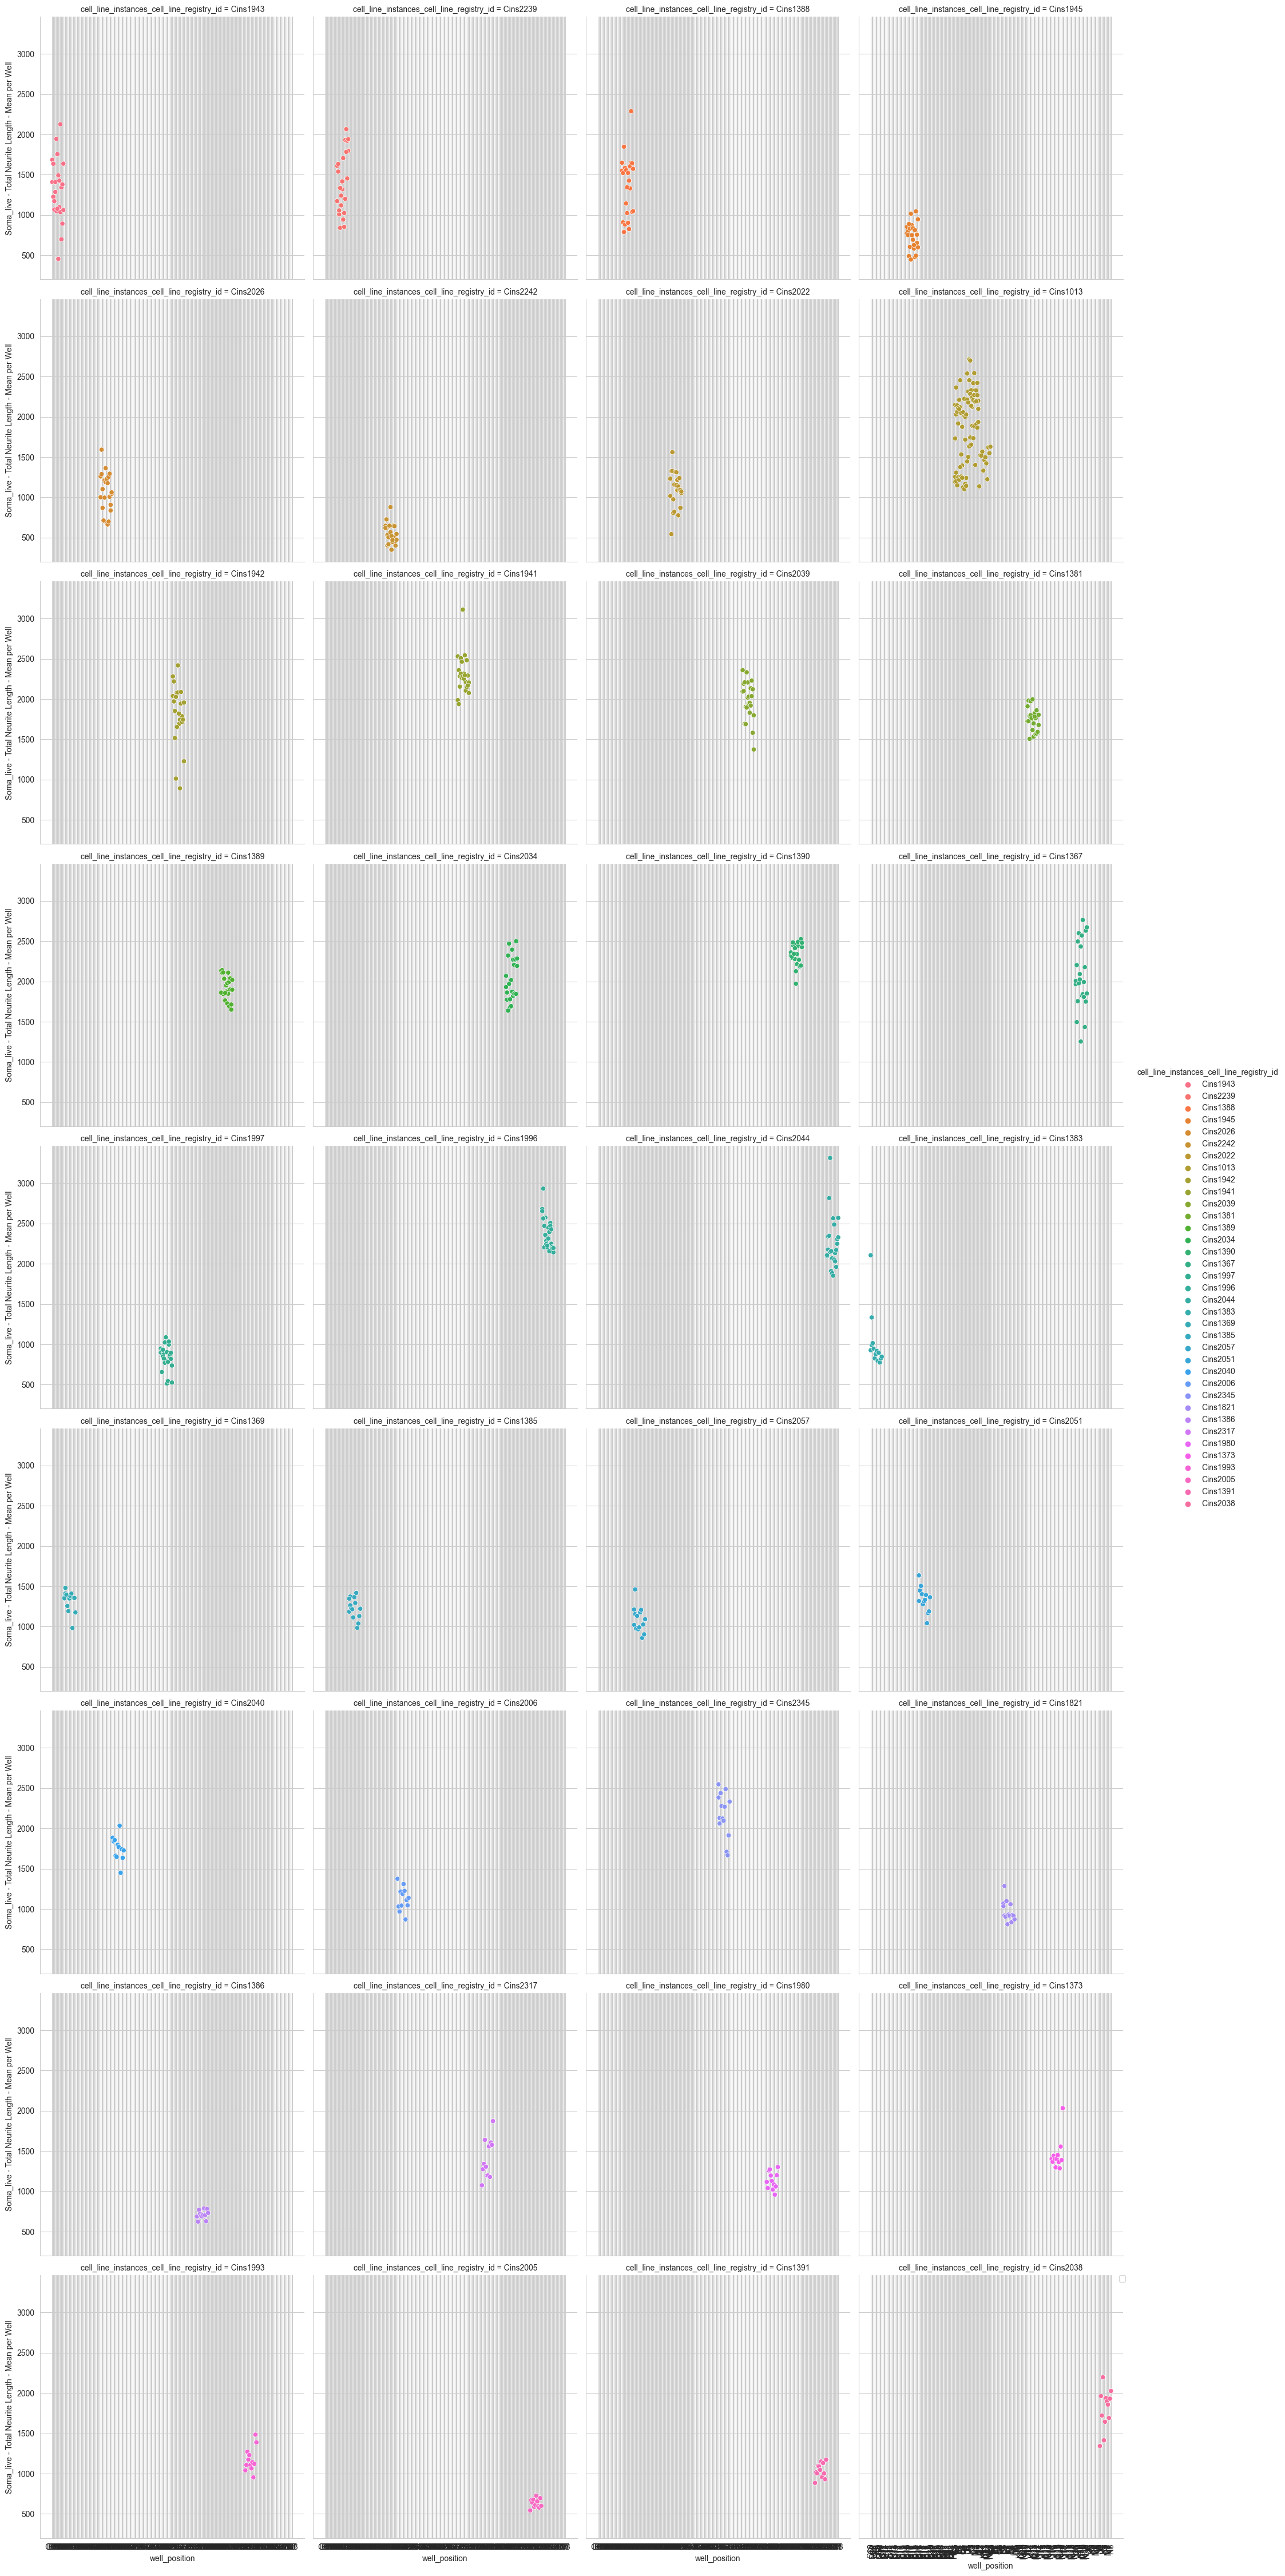

In [157]:
# QC of wells: in T0 round (DIV17 before treatment and remove outliersbefore proceeding with analysis
# Plot all_data number of objects and remove outlier wells.
# Plot 'Soma_live - Total Neurite Length - Mean per Well' by 'well_position'
df_t1 = all_data.loc[all_data['Timepoint'] == 'DIV17']
sns.relplot(x='well_position', y='Soma_live - Total Neurite Length - Mean per Well', hue='cell_line_instances_cell_line_registry_id', data=df_t1, col='cell_line_instances_cell_line_registry_id', col_wrap=4)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=2)
plt.show()

In [121]:
##FILTER# outlier cells (not finished)
#all_data = all_data[(all_data['Soma_live - Number of Objects'] >= 450) & (all_data['Soma_live - Number of Objects'] <= 3000)]

In [124]:
### T0 Normalization, separate out each plate and divide each datapoint with its matching T0 value at each well.
# load data
# Load csv here
# Create empty df for plot
plot_df = pd.DataFrame()

# Add y parameter here:
assay = ['Soma_live - Number of Objects'] #Edit this bracket with column name associated with metric. list(all_data) will show you your options.

# Add Metadata columns here:
metadata = ['PlateID','Timepoint','well_position','cell_line_instances_cell_line_registry_id', 'compound_instances_compound_name','cell_line_instances_donor.registry_id','cell_line_instances_cell_line_edit_description']

# List plates
plates = set(all_data['PlateID'])

# Subset the data by assay and merge by well position in normalized df
for plate in plates:
    data = all_data.loc[all_data['PlateID'] == plate]
    df_t1 = data.loc[data['Timepoint'] == 'DIV17', assay + metadata]
    plate_df = df_t1[metadata]
    plate_df = plate_df.drop('Timepoint', axis=1)
    
    for timepoint in data['Timepoint'].unique():
        df_timepoint = data.loc[data['Timepoint'] == timepoint, assay + ['well_position']]
        df_timepoint = pd.merge(df_timepoint[assay + ['well_position']], df_t1[assay + ['well_position']], on='well_position', suffixes=('', '_match'))
        # Divide each well by T0 of same well
        df_timepoint.insert(3, timepoint, df_timepoint.iloc[:, 0] / df_timepoint.iloc[:, 2])

        # Compile final platedf
        plate_df = pd.merge(df_timepoint[[timepoint] + ['well_position']], plate_df, on=['well_position'],)
        
    # Update the final with the normalized values and add index
    plot_df = pd.concat([plate_df, plot_df])

# Rearrange Columns
plot_df = plot_df[['DIV17', '8HPost', '24HPost','48HPost', '72HPost', '102HPost', '124HPost', '168HPost','cell_line_instances_cell_line_edit_description', 'well_position' ,'PlateID', 'cell_line_instances_cell_line_registry_id',  'cell_line_instances_donor.registry_id', 'compound_instances_compound_name']]
# Create a new column with the unique combination of "donor" and "gene edit"
plot_df['donor_and_gene'] = plot_df['cell_line_instances_donor.registry_id'] + ' ' + plot_df['cell_line_instances_cell_line_edit_description',]


# Save normalized sheet for each assay
plot_df.to_csv("T0 Normalized_Filtered" + str(assay), index=False)
    

In [161]:
# Pivot the data to wide format
plot_df_wide = plot_df.pivot(index='well_position', columns='Timepoint', values=plot_df[:8])
# Reset index and rename columns
plot_df_wide = plot_df_wide.reset_index().rename(columns={col: f"{col}_mean" for col in plot_df_wide.columns if col != 'well_position'})

# Melt the data to long format
plot_df_long = pd.melt(plot_df_wide, id_vars='well_position', var_name='Timepoint', value_name='value')

# Create a scatter plot
sns.relplot(x='Timepoint', y='value', hue='cell_line_instances_cell_line_registry_id', col='compound_instances_compound_name', col_wrap=3, kind='line', data=plot_df_long)

# Show the plot
plt.show()

KeyError: 'Timepoint'

In [169]:
plot_df[9]

KeyError: 9

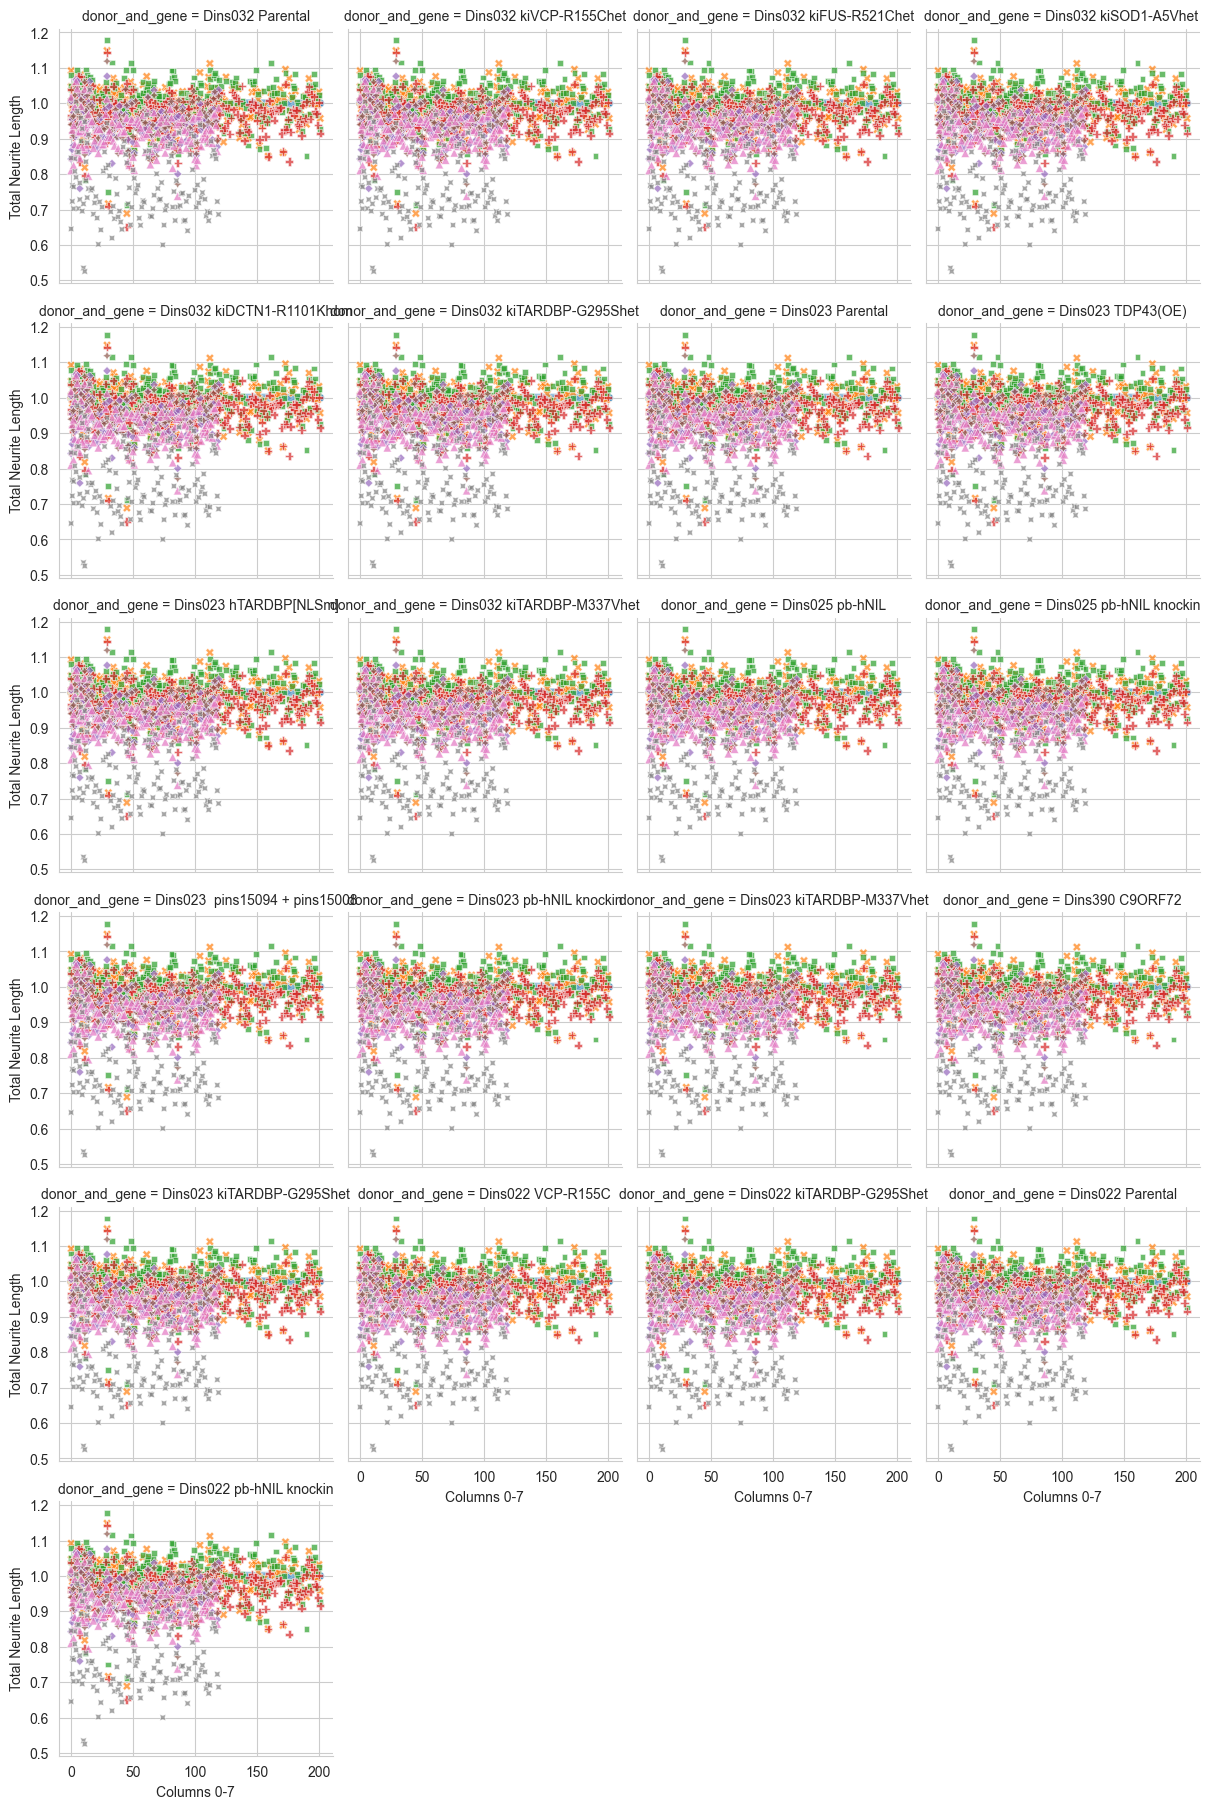

In [129]:
# Do Some plotting 
# Subset the dataframe to include only the first 7 columns
df = plot_df.iloc[:, :8]

# Create a FacetGrid with 'donor_and_gene' as the grouping variable
g = sns.FacetGrid(plot_df, col='donor_and_gene', col_wrap=4)

# Plot the range of the first 8 columns for each group
g.map(sns.scatterplot, data=df, alpha=0.7)

# Set the x and y axis labels
g.set_axis_labels('Columns 0-7', 'Total Neurite Length')


ValueError: The following variable cannot be assigned with wide-form data: `hue`

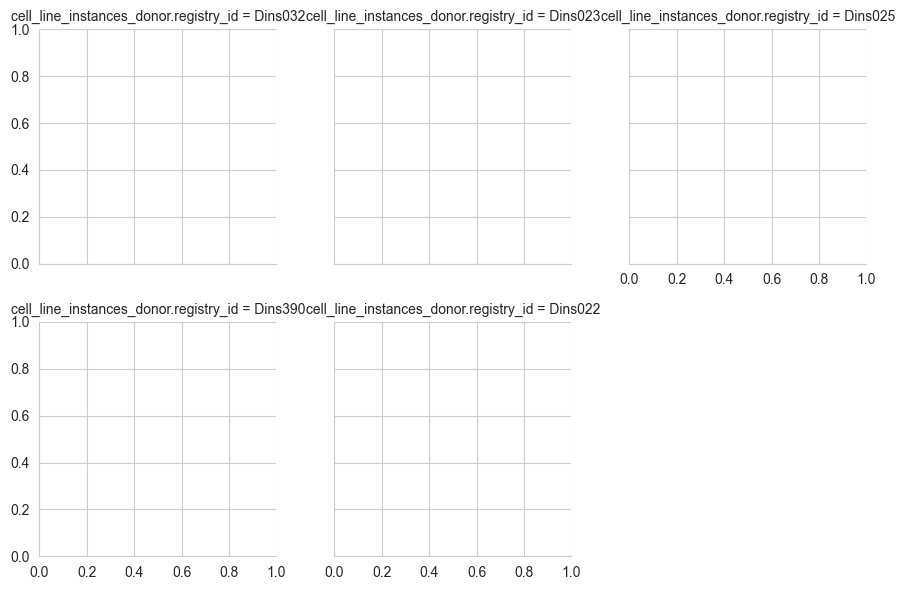

In [69]:
# Do some plotting <- Not finished.
# Load T0 Normalized data
#data = pd.read_csv("T0_Normalized_concat - Normalized.csv", delimiter = (','))
data = plot_df


# Create a new figure and axis
#fig, ax = plt.subplots()

# Calculate the mean and standard deviation for each datapoint across replicates
mean_data = data.groupby(['Donor_and_Gene', 'Treatment', 'Timepoint (h)'])['Soma_live - Number of Objects'].mean().reset_index()
std_data = data.groupby(['Donor_and_Gene', 'Treatment', 'Timepoint (h)'])['Soma_live - Number of Objects'].std().reset_index()

# Loop over each donor_and_gene and create a separate plot for each one
for donor_and_gene in mean_data['Donor_and_Gene'].unique(): 
# Create a new figure and axis for this plot
    fig, ax = plt.subplots()
# Select the subset of mean and std data for this donor_and_gene
    donor_and_gene_mean = mean_data[mean_data['Donor_and_Gene'] == donor_and_gene]
    donor_and_gene_std = std_data[std_data['Donor_and_Gene'] == donor_and_gene]    

# Loop over each treatment category and plot a line graph with error bars for it
    for treatment in donor_and_gene_mean['Treatment'].unique():
        treatment_mean = donor_and_gene_mean[donor_and_gene_mean['Treatment'] == treatment]
        treatment_std = donor_and_gene_std[donor_and_gene_std['Treatment'] == treatment]
        ax.errorbar(treatment_mean['Timepoint (h)'], treatment_mean['Soma_live - Number of Objects'], yerr=treatment_std['Soma_live - Number of Objects'], label=treatment)
        
        
    # Set the x and y axis labels
    ax.set_title(donor_and_gene)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Number of Objects')

    # Add a legend to the plot
    ax.legend()

    # Show the plot
    plt.show()

KeyError: ('cell_line_instances_donor.registry_id',)

In [48]:
### T0 Normalization, separate out each plate and divide each datapoint with its matching T0 value at each well.
# load data
# Load csv here
# Create empty df for plot
plot_df = pd.DataFrame()

# Add y parameter here: (find by listing all_data for columns)
assay = ['Neurite_outgrowth_length'] #Edit this bracket with column name associated with metric. list(all_data) will show you your options.

# Add Metadata columns here:
metadata = ['PlateID','Timepoint','well_position','cell_line_instances_cell_line_registry_id', 
 'cell_line_instances_donor.registry_id','compound_instances_compound_name']


# List plates
plates = set(all_data['PlateID'])

# Subset the data by assay and merge by well position in normalized df
for plate in plates:
    data = all_data.loc[all_data['PlateID'] == plate]
    df_t1 = data.loc[data['Timepoint'] == 'DIV17', assay + metadata]
    plate_df = df_t1[metadata]
    plate_df = plate_df.drop('Timepoint', axis=1)
    
    for timepoint in data['Timepoint'].unique():
        df_timepoint = data.loc[data['Timepoint'] == timepoint, assay + ['well_position']]
        df_timepoint = pd.merge(df_timepoint[assay + ['well_position']], df_t1[assay + ['well_position']], on='well_position', suffixes=('', '_match'))
        df_timepoint.insert(3, timepoint, df_timepoint.iloc[:, 0] / df_timepoint.iloc[:, 2])

        # Compile final platedf
        plate_df = pd.merge(df_timepoint[[timepoint] + ['well_position']], plate_df, on=['well_position'],)
    
    # Update the final with the normalized values 
    plot_df = pd.concat([plate_df, plot_df])

# Save normalized sheet for each assay
plot_df.to_csv("T0 Normalized" + str(assay), index=False)

    

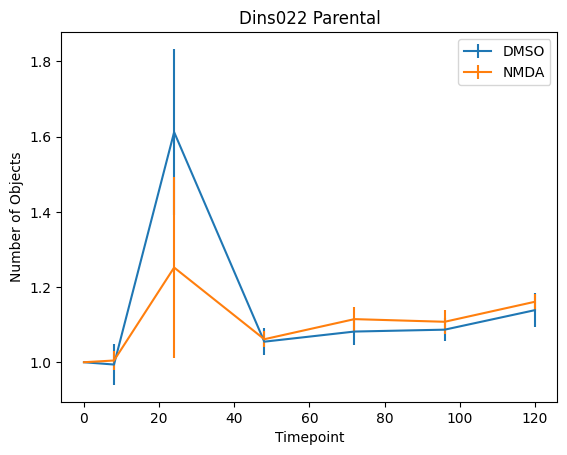

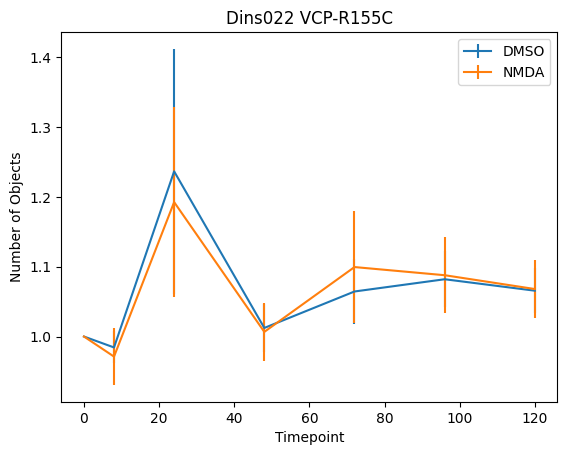

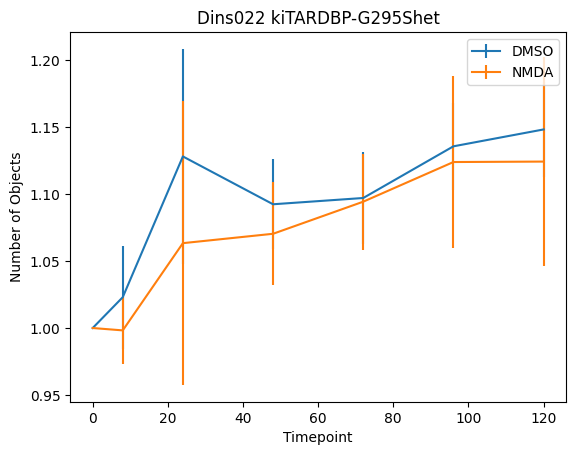

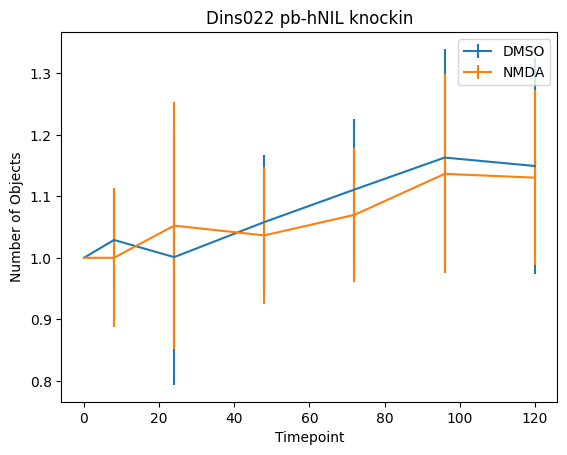

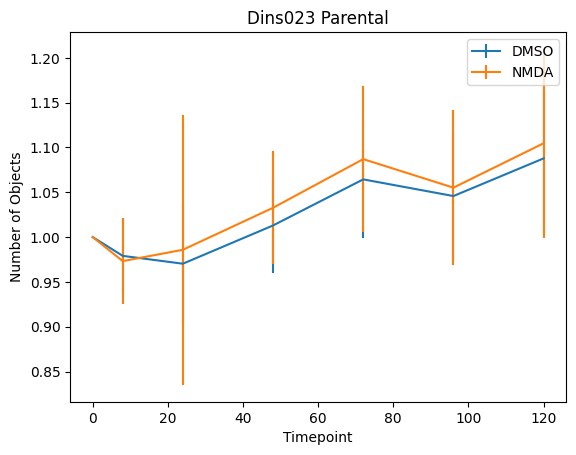

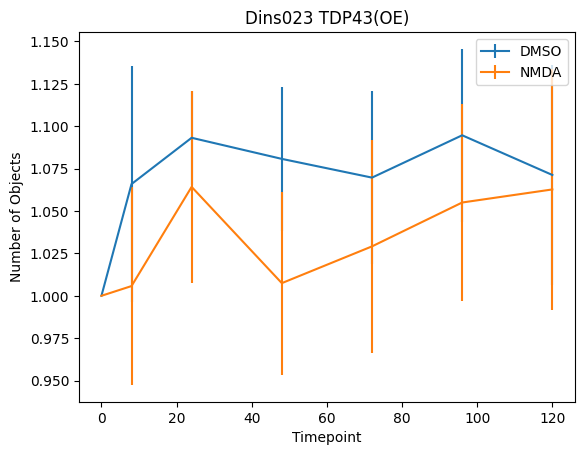

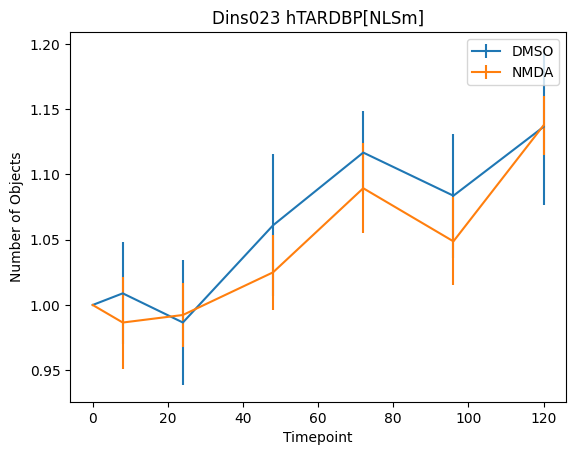

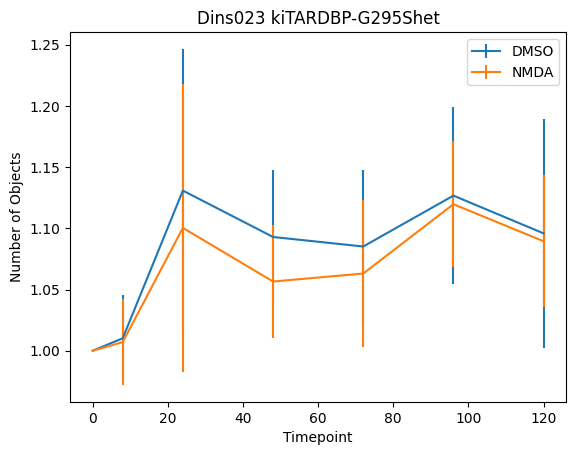

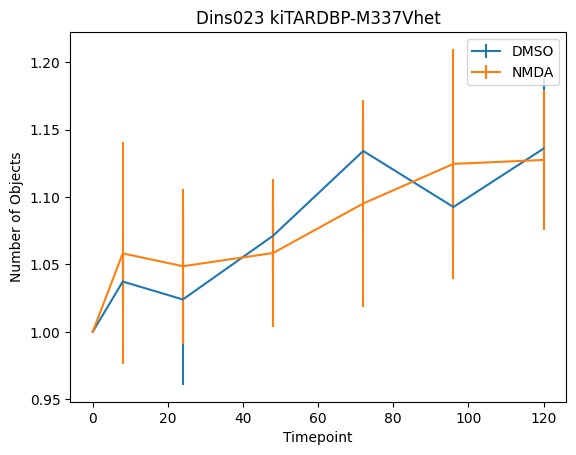

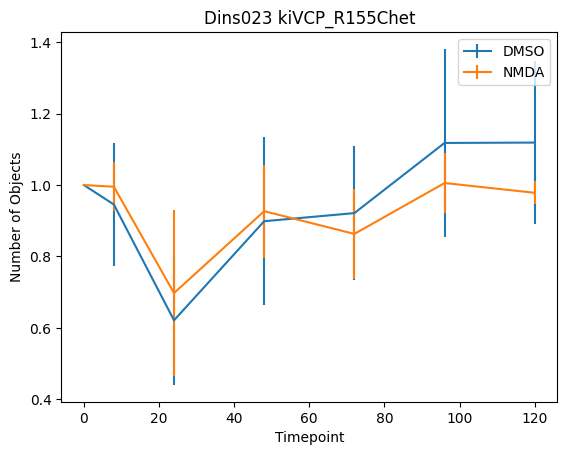

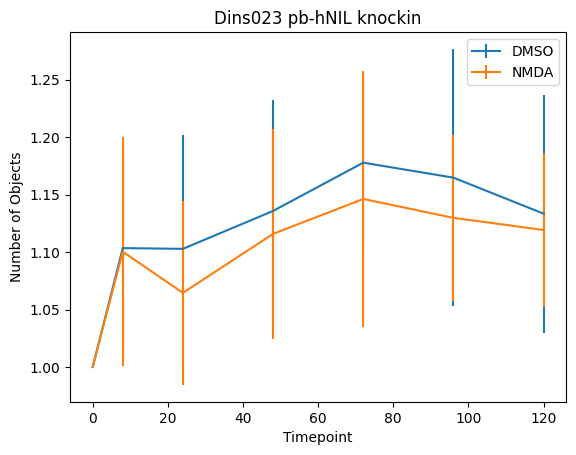

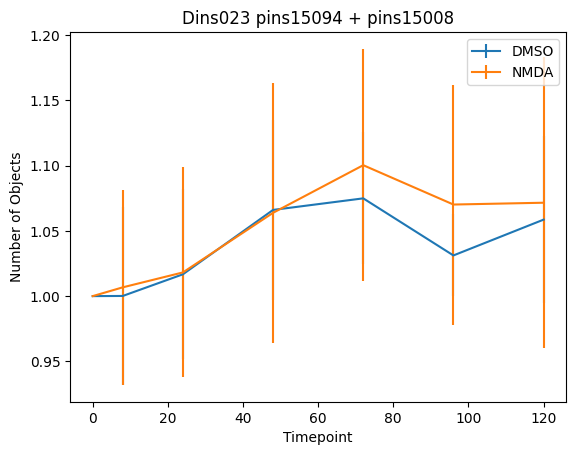

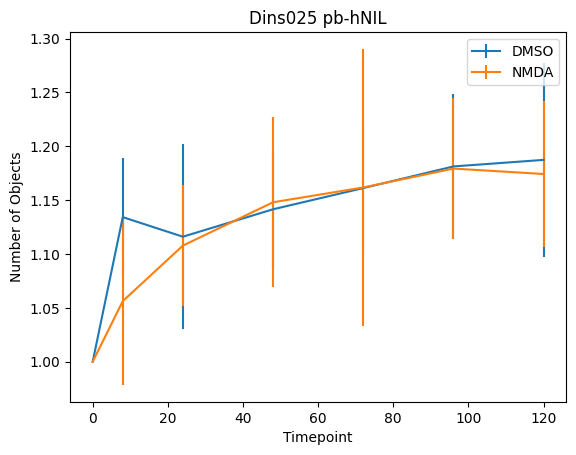

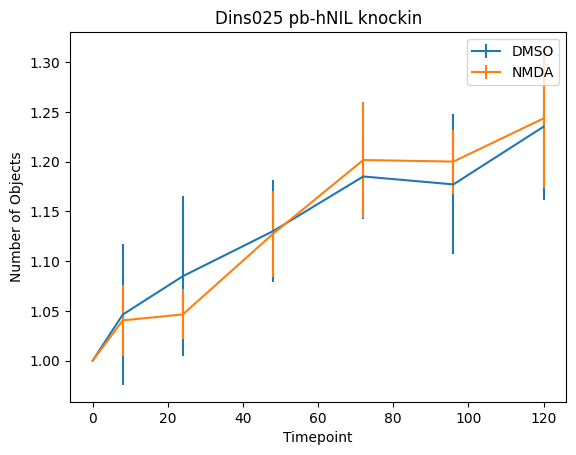

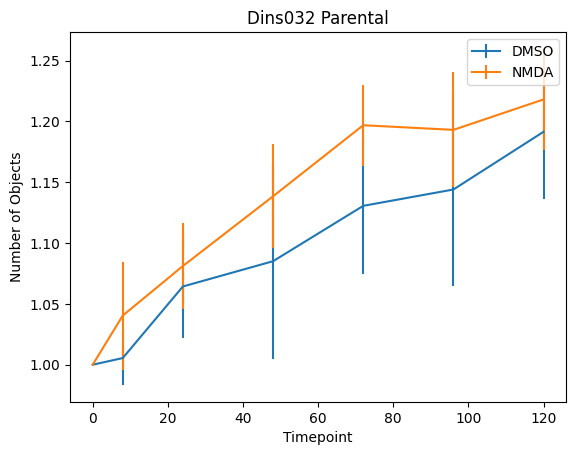

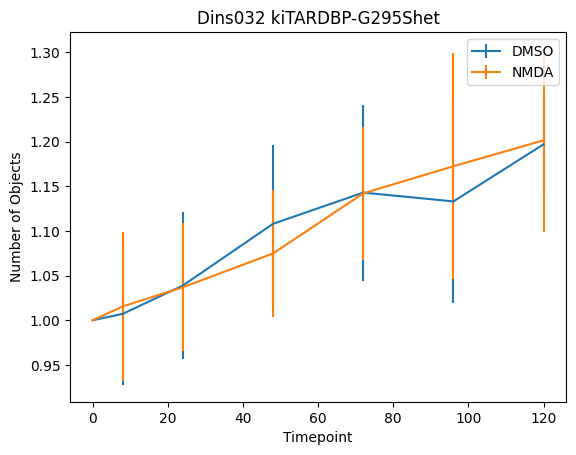

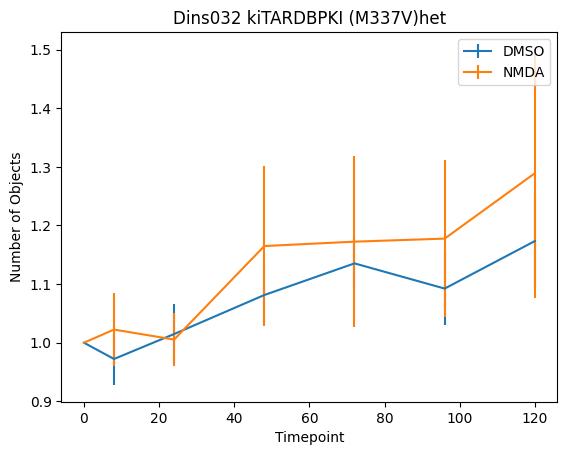

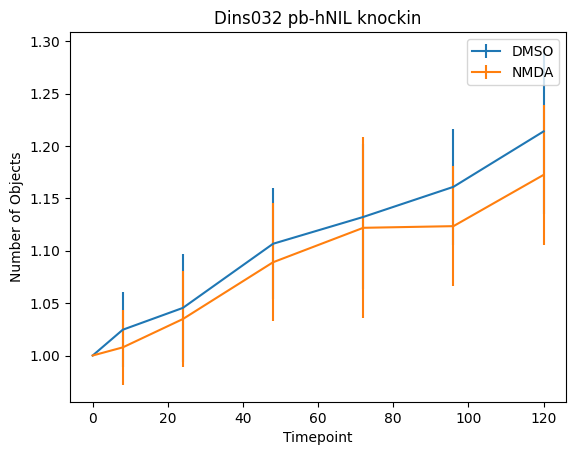

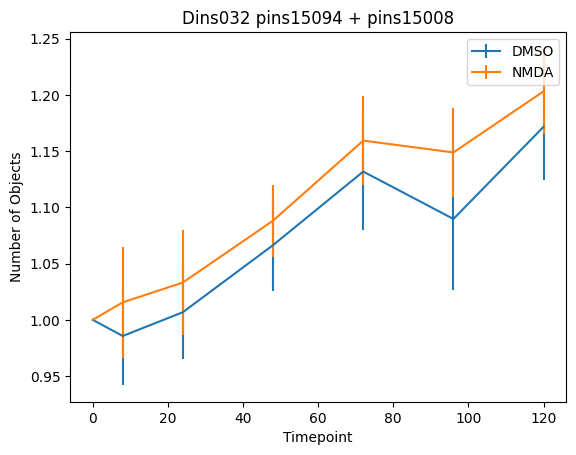

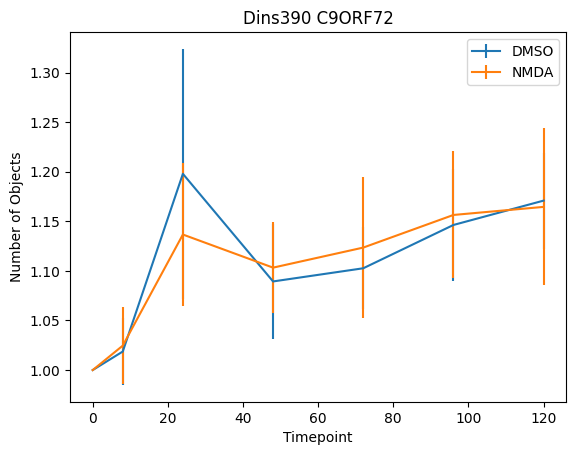

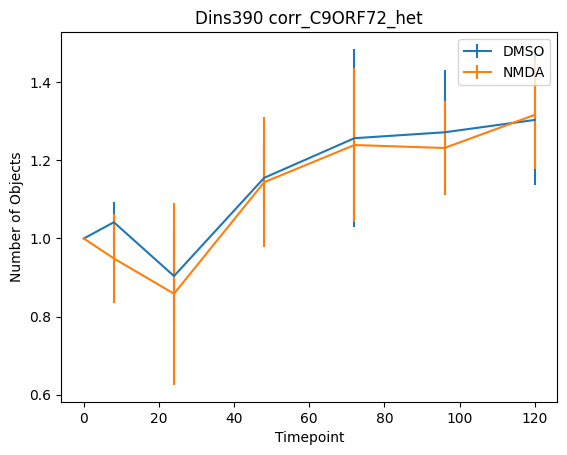

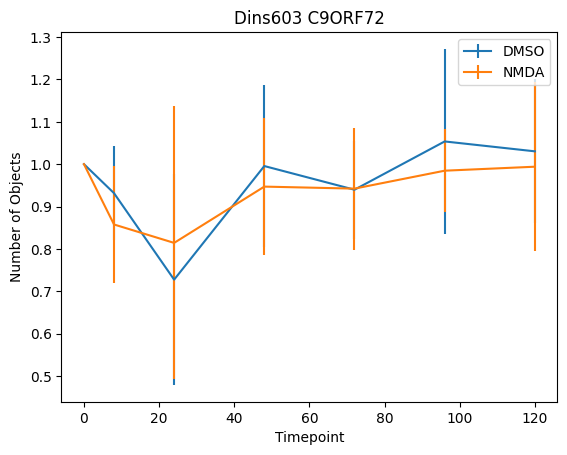

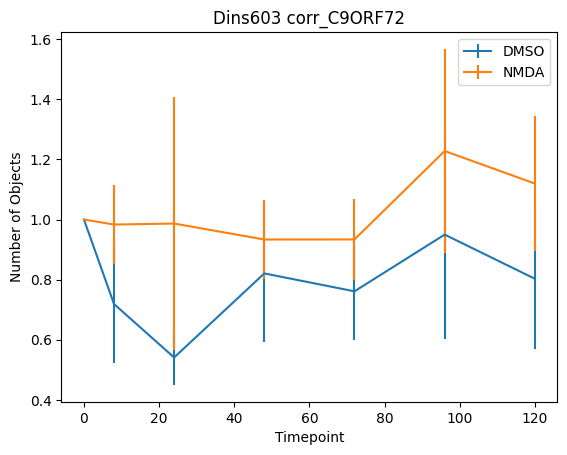

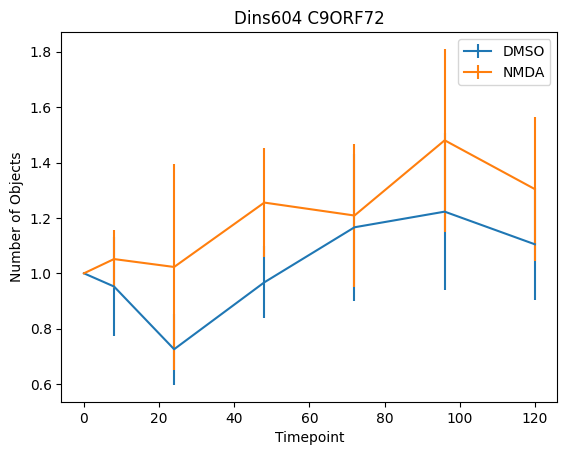

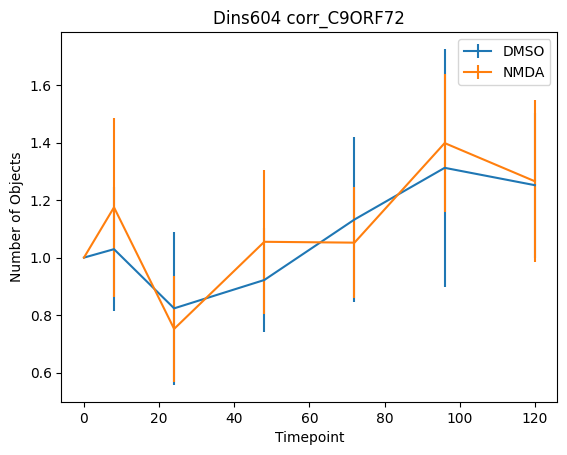

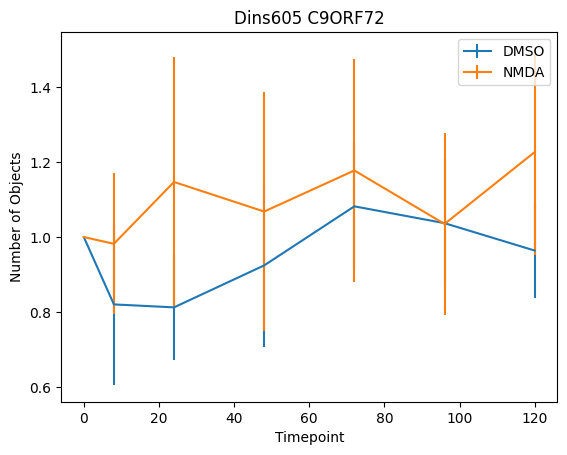

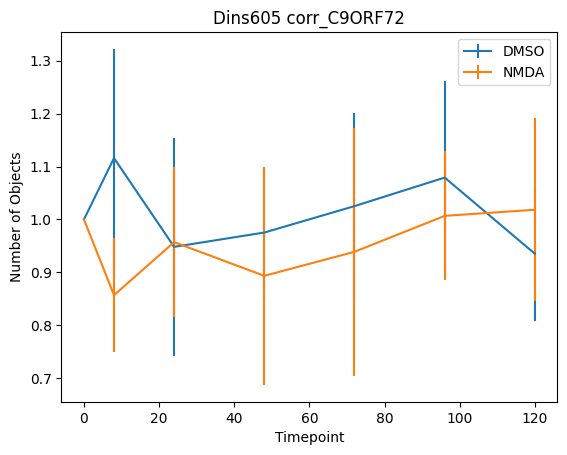

In [77]:
# Plot on new y data. (replace all soma live text with column name)
# Create a list of unique donor_and_gene combinations in the data
#donor_and_gene = data['Donor_and_Gene'].unique()

# Create a new figure and axis
#fig, ax = plt.subplots()

# Calculate the mean and standard deviation for each datapoint across replicates
mean_data = data.groupby(['Donor_and_Gene', 'Treatment', 'Timepoint (h)'])['Soma_live - Total Neurite Length - Mean per Well'].mean().reset_index()
std_data = data.groupby(['Donor_and_Gene', 'Treatment', 'Timepoint (h)'])['Soma_live - Total Neurite Length - Mean per Well'].std().reset_index()

# Loop over each donor_and_gene and create a separate plot for each one
for donor_and_gene in mean_data['Donor_and_Gene'].unique(): 
# Create a new figure and axis for this plot
    fig, ax = plt.subplots()
# Select the subset of mean and std data for this donor_and_gene
    donor_and_gene_mean = mean_data[mean_data['Donor_and_Gene'] == donor_and_gene]
    donor_and_gene_std = std_data[std_data['Donor_and_Gene'] == donor_and_gene]    

# Loop over each treatment category and plot a line graph with error bars for it
    for treatment in donor_and_gene_mean['Treatment'].unique():
        treatment_mean = donor_and_gene_mean[donor_and_gene_mean['Treatment'] == treatment]
        treatment_std = donor_and_gene_std[donor_and_gene_std['Treatment'] == treatment]
        ax.errorbar(treatment_mean['Timepoint (h)'], treatment_mean['Soma_live - Total Neurite Length - Mean per Well'], yerr=treatment_std['Soma_live - Total Neurite Length - Mean per Well'], label=treatment)
        
        
    # Set the x and y axis labels
    ax.set_title(donor_and_gene)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Number of Objects')

    # Add a legend to the plot
    ax.legend()

    # Show the plot
    plt.show()

In [74]:
# Port over plotting from Tommaso's code
#%%capture --no-display

# Dose responses with same local densities
#plot_line_pairs(
#    dfs_norm=dfs_pairs_loc_density_sampled,
#    line_pairs=sorted(dfs_pairs_loc_density_sampled.keys()),
#    feats_to_plot=['median_cyto_nucleus_mask_ratio_TDP43_pixel_intensity'],
#    compound_control=COMPOUND_CONTROL,
#)

UsageError: Line magic function `%%capture` not found.


In [71]:
# Facet plot
g = sns.FacetGrid(df, col='cell_line_instances_donor.registry_id') #, height=4, aspect=.5)
#g.map(sns.barplot, "disease", 'Soma_live - Number of Objects', order=["Healthy", "Diseased"])
g.map(sns.barplot, 'disease', 'Soma_live - Number of Objects', 
      #hue ='cell_line_instances_cell_line_edit_description',
      order=["Healthy", "Diseased"])

KeyError: 'cell_line_instances_donor.registry_id'